In [122]:
import glob
import os
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
def words_info(f_list):
    df = pd.read_csv(f_list, sep='\t')
    words_list = df.loc[:, 'label'].astype(str)
    
    words_count = words_list.value_counts()
    
    words_len = Counter(words_list.str.len().values.astype(int))
    
    letters_count = Counter(sorted(''.join(words_list)))
    
    return words_count, letters_count, words_len

In [113]:
words_count, letters_count, words_len = words_info('../../VNOnDB_word/train_word.csv')

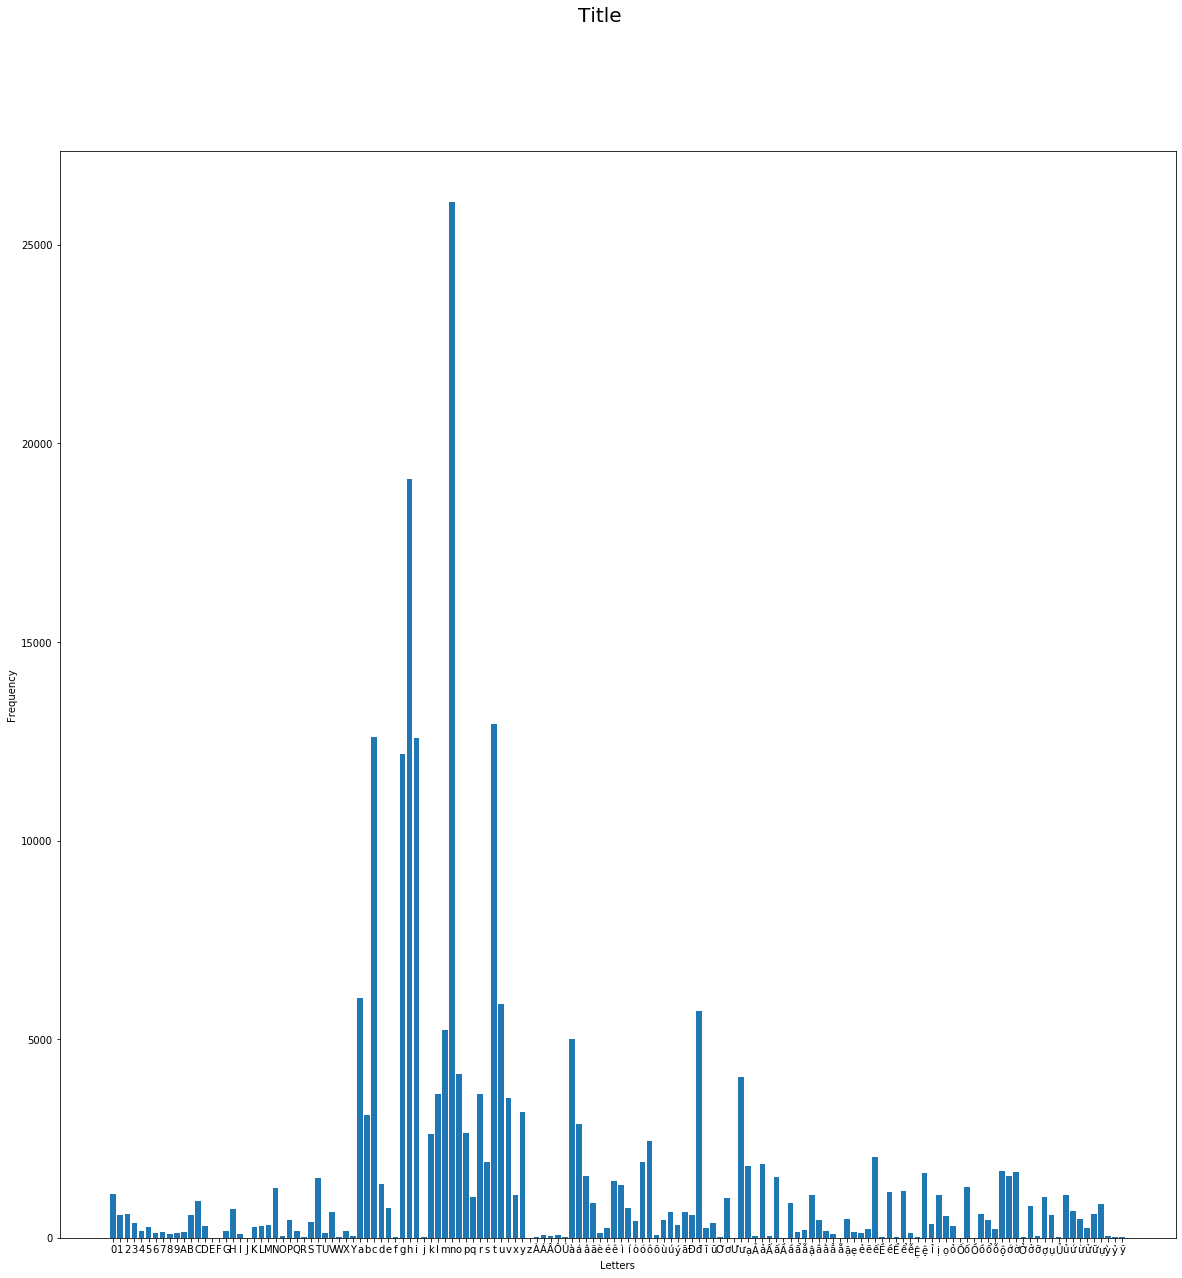

In [128]:
fig = plt.figure(figsize=(20,20))
plt.bar(letters_count.keys(), letters_count.values())

fig.suptitle('Title', fontsize=20)
plt.xlabel('Letters', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
fig.savefig('letters_count.jpg', dpi=100)

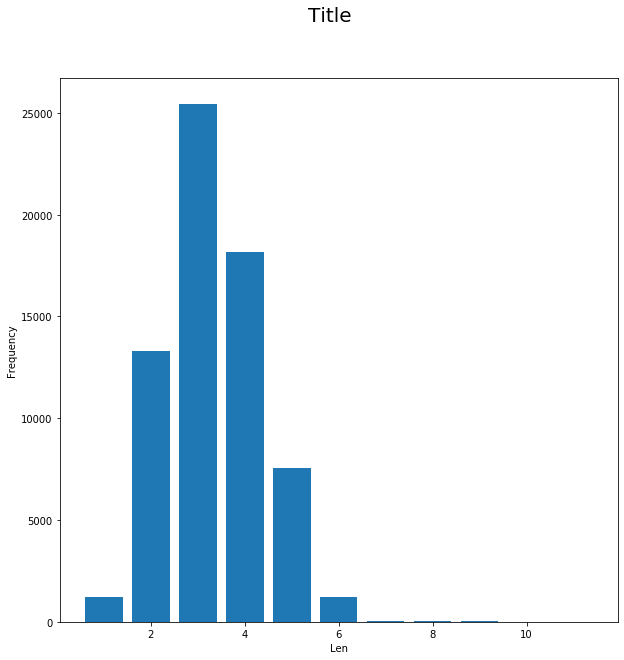

In [131]:
fig = plt.figure(figsize=(10,10))
plt.bar(words_len.keys(), words_len.values())

fig.suptitle('Title', fontsize=20)
plt.xlabel('Len', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
fig.savefig('words_len.jpg', dpi=300)